# Non-supervised gating of the data via the front and side scattering.

In [1]:
import os
import glob
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy

import mwc_induction_utils as mwc

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

mwc.set_plotting_style()

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Datashader to plot lots of datapoints
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
from IPython.core.display import HTML, display

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()
bokeh.plotting.output_notebook()

Loading BokehJS ...

Loading BokehJS ...

# Plotting all of the data with datashader

In this notebook we will develop an automatic procedure to gate the flow cytometry data based on the front and side scattering lectures returned by the equipment. 
We will use Python's amazing `datashader` library in combination with `Bokeh` to generate interactive plots with an arbitrary number of data points really easily

Let's first read an example data set. We will be working with the LacI titration data set generated on `20160804`.

In [23]:
# define the date to find the experiment files
date = 20160804

# list the directory with the data
datadir = '../../data/flow/csv/'
files = np.array(os.listdir(datadir))

# select the files from the chosen date
csv_bool = np.array([str(date) in f and 'csv' in f for f in files])
files = files[np.array(csv_bool)]

# Read files into a pandas Data Frame
df_example = pd.read_csv(datadir + files[1])
df_example.head()

Unnamed: 0      HDR-T         FSC-A         FSC-H          FSC-W  \
0           0   5.234742   4931.073730   7329.625000   88179.914062   
1           1   9.376796   6684.469727   7270.852539  120501.250000   
2           2  11.028535  47620.460938  34441.476562  181226.515625   
3           3  14.696243   6008.482422   6114.314453  128803.289062   
4           4  17.847254   9215.087891   6789.694336  177893.140625   

           SSC-A         SSC-H          SSC-W       FITC-A       FITC-H  \
0   24927.375000  21066.142578  155096.312500  3863.893066  5620.254883   
1   29407.791016  22308.511719  172783.281250  1327.978760  6212.779785   
2  126428.734375  83701.867188  197979.656250  9810.027344  6209.653320   
3    7114.638672   5086.319336  183340.812500 -1113.539673  3575.527588   
4   43032.671875  28439.339844  198330.140625 -1728.413940  2786.592529   

          FITC-W   APC-Cy7-A   APC-Cy7-H     APC-Cy7-W  
0   90111.250000  198.227966  303.540833  85596.835938  
1   28016.578125   56.292591  269.903198  27337.144531  
2  207067.906250  131.344498  370.191162  46504.585938  
3  -40820.234375   52.552475  162.486893  42392.082031  
4  -81298.812500   -0.379246  235.683441   -210.912140

Now in order to use `datashader` in an interactive `Bokeh` plot we need to define a `base_plot` function to initialize a `Bokeh` plot canvas.

In [35]:
def base_plot(df, x_col, y_col, log=False):
    '''
    Initialize canvas to plot the flow cytometry raw data with Bokeh.
    Parameters
    ----------
    df : Pandas dataframe.
        Data frame containing the data to be plotted.
    x_col, y_col : str.
        Name of the dataframe columns containing the x and y data 
        respectively to be plotted.
    log : bool.
        Boolean indicating if the data should be plotted in log_10 scale.
        NOTE: Since Bokeh is known to have issues with plotting in log scale
        rather than changing the axis to log scale the function computes
        explicitly the log base 10 value of each datum.
    '''

    x_range = (df[x_col].min(), df[x_col].max())
    y_range = (df[y_col].min(), df[y_col].max())
        
    # Initialize the Bokeh plot
    p = bokeh.plotting.figure(
        x_range=x_range,
        y_range=y_range,
        tools='save,pan,wheel_zoom,box_zoom,reset', 
        plot_width=500, 
        plot_height=500,
    )
    
    # Add all the features to the plot
    p.xgrid.grid_line_color = '#a6a6a6'
    p.ygrid.grid_line_color = '#a6a6a6'
    p.ygrid.grid_line_dash = [6, 4]
    p.xgrid.grid_line_dash = [6, 4]
    if log:
        p.xaxis.axis_label = 'log ' + x_col
        p.yaxis.axis_label = 'log ' + y_col
    else:
        p.xaxis.axis_label = x_col
        p.yaxis.axis_label = y_col
    p.xaxis.axis_label_text_font_size = '15pt'
    p.yaxis.axis_label_text_font_size = '15pt'
    p.background_fill_color = '#E3DCD0'
    return p

With this in hand we define a simple function that takes one of our data frames and plots whichever columns we want on a 2-D scatter plot.

In [36]:
def ds_plot(df, x_col, y_col, log=False):
    if log:
        data = np.log10(df[[x_col, y_col]])
    else:
        data = df[[x_col, y_col]]
    p = base_plot(data, x_col, y_col, log=log)
    pipeline = ds.Pipeline(data, ds.Point(x_col, y_col))
    return p, pipeline

Now let's plot the front and side scattering channels we will use for the gating. 
The amaing features about `datashader` is that we can plot **all of the data points** (>100,000) basically instantly.

In [39]:
p, pipeline = ds_plot(df_example, 'FSC-A', 'SSC-A', log=True)
InteractiveImage(p, pipeline)

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


# Automatic gate

To get some sense of potentials ways to automatically gate the data let's first plot a Kernel Density Estimation to get a sense of where does most of the data-points density is.

We will use the convenient `jointplot` from `seaborn` to make a KDE plot of these scattering.

First let's take a look at the linear scattering data.

/Users/razo/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


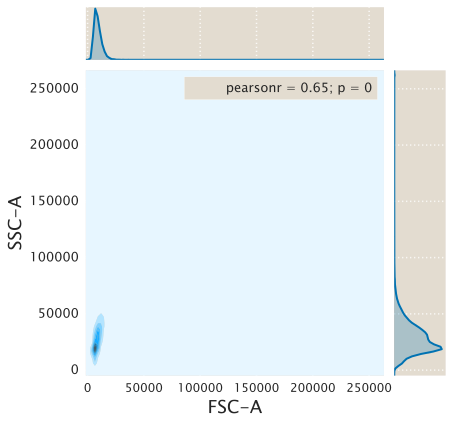

In [11]:
sns.jointplot(x='FSC-A', y='SSC-A', data=df_example, kind="kde");

Then the log of the scattering.

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/razo/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


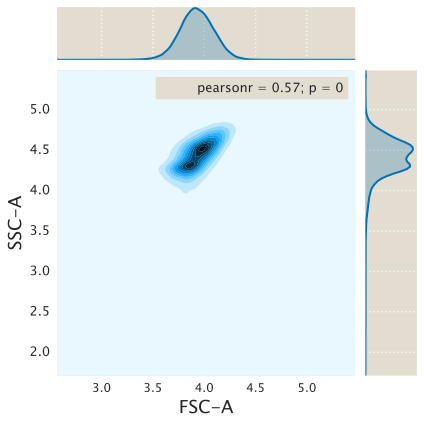

In [12]:
sns.jointplot(x='FSC-A', y='SSC-A', 
              data=np.log10(df_example[['FSC-A', 'SSC-A']]), kind="kde");

From this last plot the marginal distributions look relatively unimodal. The slight bi-modality shown on the side scattering is not a common feature on all data sets and bot peaks are relatively close to each other such that the proposed automatic gating procedure will be relatively insensitive to them.

We propose setting an automatic gate by **fitting a bivariate Gaussian distribution** to the $\log$ front and $\log$ side scattering and then selecting an interval that contains a fraction $\alpha$ of the total data (for example 40% of the data).

For this we need a robut function to fit a 2D Gaussian matrix to the data. We will take advantage of the `astroML` [`fit_bivariate_normal`](http://www.astroml.org/book_figures/chapter3/fig_robust_pca.html) function to estimate the mean $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$.

In [40]:
def fit_2D_gaussian(df, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    This function hacks astroML fit_bivariate_normal to return the mean and
    covariance matrix when fitting a 2D gaussian fuction to the data contained
    in the x_vall and y_val columns of the DataFrame df.
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not
        
    Returns
    -------
    mu : tuple.
        (x, y) location of the best-fit bivariate normal
    cov : 2 x 2 array
        covariance matrix.
        cov[0, 0] = variance of the x_val column
        cov[1, 1] = variance of the y_val column
        cov[0, 1] = cov[1, 0] = covariance of the data
    '''
    if log:
        x = np.log10(df[x_val])
        y = np.log10(df[y_val])
    else:
        x = df[x_val]
        y = df[y_val]
        
    # Fit the 2D Gaussian distribution using atroML function
    mu, sigma_1, sigma_2, alpha = mwc.fit_bivariate_normal(x, y, robust=True)

    # compute covariance matrix from the standar deviations and the angle
    # that the fit_bivariate_normal function returns
    sigma_xx = ((sigma_1 * np.cos(alpha)) ** 2
                + (sigma_2 * np.sin(alpha)) ** 2)
    sigma_yy = ((sigma_1 * np.sin(alpha)) ** 2
                + (sigma_2 * np.cos(alpha)) ** 2)
    sigma_xy = (sigma_1 ** 2 - sigma_2 ** 2) * np.sin(alpha) * np.cos(alpha)
    
    # put elements of the covariance matrix into an actual matrix
    cov = np.array([[sigma_xx, sigma_xy], [sigma_xy, sigma_yy]])
    
    return mu, cov

Then to compute the interval that contains a fraction $\alpha$ of the data we follow [this procedure](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Interval) in which for a 2D Gaussian distributiuon an elliptic region defined by
\begin{equation}
\left(\mathbf{x} - \mathbf{\mu} \right)^T \mathbf{\Sigma}^{-1} \left(\mathbf{x} - \mathbf{\mu} \right) \leq \chi^2_{2, \alpha}(p)
\end{equation}
contains $\alpha\ \times 100$ % of the data. $\chi^2_{2, \alpha}(p)$ is the  quantile function for probability $p$ of the chi-squared distribution with $2$ degrees of freedom.

Let's define a function to compute the left hand side of the inequality for our data.

In [41]:
def gauss_interval(df, mu, cov, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    Computes the of the statistic
    (x - µx)'∑(x - µx) 
    for each of the elements in df columns x_val and y_val.
    
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    mu : array-like.
        (x, y) location of bivariate normal
    cov : 2 x 2 array
        covariance matrix
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not 
    
    Returns
    -------
    statistic_gauss : array-like.
        array containing the result of the linear algebra operation:
        (x - µx)'∑(x - µx) 
    '''
    # Determine that the covariance matrix is not singular
    det = np.linalg.det(cov)
    if det == 0:
        raise NameError("The covariance matrix can't be singular")
            
    # Compute the vector x defined as [[x - mu_x], [y - mu_y]]
    if log: 
        x_vect = np.log10(np.array(df[[x_val, y_val]]))
    else:
        x_vect = np.array(df[[x_val, y_val]])
    x_vect[:, 0] = x_vect[:, 0] - mu[0]
    x_vect[:, 1] = x_vect[:, 1] - mu[1]
    
    # compute the inverse of the covariance matrix
    inv_sigma = np.linalg.inv(cov)
    
    # compute the operation
    interval_array = np.zeros(len(df))
    for i, x in enumerate(x_vect):
        interval_array[i] = np.dot(np.dot(x, inv_sigma), x.T)
        
    return interval_array

Now that we defined the functions let's fit a 2D gaussian to our $\log$ scattering data and then compute the interval statistic.

In [42]:
# Fit the bivariate Gaussian distribution
mu, cov = fit_2D_gaussian(df_example, log=True)

# Compute the statistic for each of the pair of log scattering data
interval_array = gauss_interval(df_example, mu, cov, log=True)

/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in log10
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in log10
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log10


Having the statistic allows us to compare it to the $\chi^2$ quantile function. Just as in the 68-95-99.7% rule for 1D Gaussians let us choose an arbitrary threshold to keep 40% of the data density.

To compute the $\chi^2$ quantile funciton we will use the `scipy.stats.chi2.ppf` function.

In [43]:
alpha = 0.40

# Find which data points fall inside the interval
idx = interval_array <= scipy.stats.chi2.ppf(alpha, 2)
print('''
Fraction of the data kept after the alpha = {0:0.2f} threshold:
{1:0.2f}
'''.format(alpha, np.sum(idx) / len(interval_array)))


Fraction of the data kept after the alpha = 0.40 threshold:
0.41



/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


Let's apply the threshold to our data and plot it again using `datashader`.

In [44]:
# Apply the threshold to the data
df_thresh_gauss = df_example[idx]

### $\log$ scattering

In [45]:
p, pipeline = ds_plot(df_thresh_gauss, 'FSC-A', 'SSC-A', log=True)
InteractiveImage(p, pipeline)

This looks pretty good! Let's now plot this thresholded data on a linear scale.

In [46]:
p, pipeline = ds_plot(df_thresh_gauss, 'FSC-A', 'SSC-A', log=False)
InteractiveImage(p, pipeline)

It looks much better than the arbitrary thresholds set by eye!

After processing the data using a value of $\alpha = 0.4$ let's look at the results from this experiment.

We will read a pre-processed `pandas DataFrame` that contains all the fold changes for these strains.

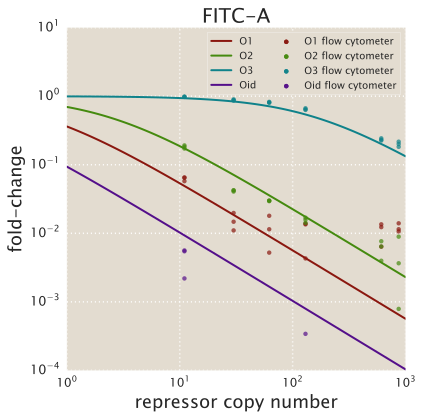

In [54]:
# define variables to use over the script
date = 20160725
username = 'mrazomej'

# read the CSV file with the mean fold change
df_preprocess = pd.read_csv('../../data/' + str(date) +\
                            '_lacI_titration_MACSQuant.csv', comment='#')

rbs = df_preprocess.rbs.unique()
replica = df_preprocess.replica.unique()

# compute the theoretical repression level
repressor_array = np.logspace(0, 3, 100)
epsilon_array = np.array([-15.3, -13.9, -9.7, -17])
operators = np.array(['O1', 'O2', 'O3', 'Oid'])

colors = sns.hls_palette(len(operators), l=.3, s=.8)
# plot theoretical curve
# First for the A channel
plt.figure(figsize=(6,6))
for i, o in enumerate(operators):
    fold_change_theor = 1 / (1 + 2 * repressor_array / 5E6 \
            * np.exp(-epsilon_array[i]))
    plt.plot(repressor_array, fold_change_theor, label=o,
            color=colors[i])
    plt.scatter(df_preprocess[(df_preprocess.operator == o) & \
                              (df_preprocess.rbs != 'auto') & \
            (df_preprocess.rbs != 'delta')].repressors, 
            df_preprocess[(df_preprocess.operator == o) & \
                          (df_preprocess.rbs != 'auto') & \
            (df_preprocess.rbs != 'delta')].fold_change_A,
            marker='o', linewidth=0, color=colors[i], 
            label=o + ' flow cytometer',
            alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('repressor copy number')
plt.ylabel('fold-change')
plt.title('FITC-A')
plt.xlim([1, 1E3])
plt.legend(loc=0, ncol=2, fontsize=10)
plt.tight_layout()

It looks quite decent and it didn't involve manually choosing gates for the scattering data. The only parameter we set was the fraction $\alpha$ that we wanted to keep of the data.

Let's finally define a function that returns a thresholded `DataFrame`.

In [52]:
def auto_gauss_gate(df, alpha, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    Function that applies an "unsupervised bivariate Gaussian gate" to the data
    over the channels x_val and y_val.
    
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    alpha : float. [0, 1]
        fraction of data aimed to keep. Used to compute the chi^2 quantile function
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not 
    '''
    data = df[[x_val, y_val]]
    # Fit the bivariate Gaussian distribution
    mu, cov = fit_2D_gaussian(data, log=log)

    # Compute the statistic for each of the pair of log scattering data
    interval_array = gauss_interval(data, mu, cov, log=log)
    
    # Find which data points fall inside the interval
    idx = interval_array <= scipy.stats.chi2.ppf(alpha, 2)
    
    return df[idx]